<a id='sec0'></a>
# Predictive annotation of quantification methods 5
Idea is to use the descriptive text for each dataset to predict which quantification method was used for the experiments for the dataset. Below is an outline for the process.<br>
- <a href='#sec4'><b>Classification for itraq</b></a>

In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import gensim
from gensim import corpora, models
from gensim import matutils
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
        accuracy_score, precision_score, recall_score,
        average_precision_score, f1_score,
        brier_score_loss, classification_report,
        precision_recall_curve, roc_auc_score, roc_curve)

#### Loading data

In [3]:
if True:
    with open('serialized_data/processed_df_plus_dummies.pickle', 'rb') as out_df:
        df =pickle.load(out_df)
    
    sample_tfidf = corpora.MmCorpus('nlp13_data/sample_tfidf.mm')
    data_tfidf = corpora.MmCorpus('nlp13_data/data_tfidf.mm')
    protocols_tfidf = corpora.MmCorpus('nlp13_data/protocols_tfidf.mm')
    description_tfidf = corpora.MmCorpus('nlp13_data/description_tfidf.mm')
    whole_tfidf = corpora.MmCorpus('nlp13_data/whole_tfidf.mm')
    my_dictionary = corpora.Dictionary.load('nlp13_data/whole_dictionary.dict')
    print(my_dictionary)

Dictionary(22736 unique tokens: ['-pron-', 'activation', 'aggressive', 'alkylation', 'also']...)


In [4]:
df.head(2)

,dataset_id,sample_protocol,data_protocol,description,quant_methods,silac,ms1_label_free,spectrum_counting,tmt,itraq,label_free
0,PXD000029,"[breast, cancer, tissue, lysate, reduction, al...","[proteomic, datum, analysis, proteome, discove...","[current, prognostic, factor, insufficient, pr...",itraq,0,0,0,0,1,0
1,PXD000164,"[protein, extraction, catheter, biofilm, small...","[mass, spectrometric, analyse, the, tryptic, d...","[long, term, catheterization, lead, inevitably...",label free,0,0,0,0,0,1


#### Functions for classification tasks

In [9]:
def classifyCV(clf, corpus, target, name=None, n_splits=5, num_terms=22736):
    # Set features and y
    if type(corpus) == np.ndarray:    # This is just for convenience later. Not a good coding design though.
        X = corpus
    else:
        X = matutils.corpus2dense(corpus, num_terms=num_terms).T
    y = np.array(target)
    
    # Cross Validation Loop
    kf = KFold(n_splits=n_splits)
    results = []
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        
        # create result dictionary
        result = {}
        result['classifier'] = name

        # Fit a model and predict
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)
        
        # Get metrics
        result['CV_fold'] = n_splits
        result['accuracy'] = accuracy_score(y_test, y_pred)
        result['precision'] = precision_score(y_test, y_pred)
        result['recall'] = recall_score(y_test, y_pred)
        result['average_precision'] = average_precision_score(y_test, y_proba[:, 1])
        result['Brier_loss'] = brier_score_loss(y_test, y_proba[:, 1])
        result['f1'] = f1_score(y_test, y_pred)

        fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
        result['fpr'] = fpr
        result['tpr'] = tpr
        result['roc_auc'] = roc_auc_score(y_test, y_proba[:, 1])
        
        precision_, recall_, _ = precision_recall_curve(y_test, y_proba[:, 1])
        result['precision_vals'] = precision_
        result['recall_vals'] = recall_

        results.append(result)
            
    results = pd.DataFrame(results)
    
    return results

def get_stats(results, label):
    col = results[label]
    mean = col.mean()
    std = col.std()
    print('%s: %.2f +/- %.3f' % (label, mean, std))
    return

def summarize_results(results, clf_label='', target_label='', plot_result=True):
    score_cols = [
        'accuracy',
        'precision',
        'recall',
        'f1',
        'average_precision',
        'roc_auc',
        'Brier_loss',
    ]
    print('='*10, '%s %d-fold CV stats' % (clf_label, len(results)), '='*10)
    for col in score_cols:
        get_stats(results, col)
    
    if plot_result:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        t = np.linspace(0, 1, 10)
        ax1.plot(t, t, ls='--', lw=0.5, color='0.3')
        for i in range(len(results)):
            fpr = results.fpr.iloc[i]
            tpr = results.tpr.iloc[i]
            ax1.plot(fpr, tpr, label=('CV %d' % (i+1)))
            ax1.set_xlabel('False Positive Rate')
            ax1.set_ylabel('True Positive Rate')
            ax1.set_title('ROC: %s. (\'%s\')' % (clf_label, target_label))
            ax1.legend()

            precision_vals = results.precision_vals.iloc[i]
            recall_vals = results.recall_vals.iloc[i]
            ax2.plot(recall_vals, precision_vals, label=('CV %d' % (i+1)))
            ax2.set_xlabel('Recall')
            ax2.set_ylabel('Precision')
            ax2.set_title('Precision-Recall: %s (\'%s\')' % (clf_label, target_label))
            ax2.legend()

        fig.tight_layout()
    return

<a id='sec4'></a>
## itraq

#### Feature Selection

/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklea

========== RFC 5-fold CV stats ==========
accuracy: 0.89 +/- 0.046
precision: 0.00 +/- 0.000
recall: 0.00 +/- 0.000
f1: 0.00 +/- 0.000
average_precision: 0.79 +/- 0.104
roc_auc: 0.94 +/- 0.027
Brier_loss: 0.09 +/- 0.032


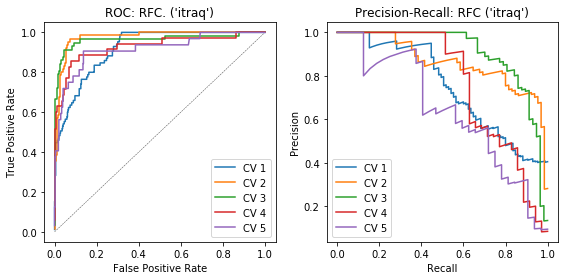

In [10]:
rfc = RandomForestClassifier(max_depth=5, n_estimators=100, n_jobs=8)
initial_results = classifyCV(rfc, protocols_tfidf, df.itraq,
    name='RFC', n_splits=5, num_terms=22736)
summarize_results(initial_results, clf_label='RFC', target_label='itraq')

In [7]:
# Get number of non-zero features
rfc.n_features_, np.count_nonzero(rfc.feature_importances_)

(22736, 778)

In [20]:
pd.Series(rfc.feature_importances_).describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    22736.000000
mean         0.000044
std          0.000508
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
90%          0.000000
95%          0.000000
99%          0.001045
max          0.032203
dtype: float64

In [21]:
X0 = matutils.corpus2dense(protocols_tfidf, num_terms=22736).T

new_inds1 = np.argwhere(rfc.feature_importances_ >= 0.001).flatten()
new_inds2 = np.argwhere(rfc.feature_importances_ >= 0.005).flatten()
new_inds3 = np.argwhere(rfc.feature_importances_ >= 0.01).flatten()
new_inds4 = np.argwhere(rfc.feature_importances_ >= 0.02).flatten()

X1 = X0[:, new_inds1]
X2 = X0[:, new_inds2]
X3 = X0[:, new_inds3]
X4 = X0[:, new_inds4]

print('Shape before:', X0.shape)
print('Shape X1   :', X1.shape)
print('Shape X2   :', X2.shape)
print('Shape X3   :', X3.shape)
print('Shape X3   :', X4.shape)

Shape before: (2387, 22736)
Shape X1   : (2387, 244)
Shape X2   : (2387, 36)
Shape X3   : (2387, 12)
Shape X3   : (2387, 3)


In [22]:
# Check fraction of spectrum_counting class
print('Fraction with spectrum_counting = %.2f%%' % (100*df.itraq.sum()/len(df)))

Fraction with spectrum_counting = 11.48%


##### With RFC

In [23]:
rfcX1 = RandomForestClassifier(max_depth=10, n_estimators=100, n_jobs=8)
rfcX2 = RandomForestClassifier(max_depth=10, n_estimators=100, n_jobs=8)
rfcX3 = RandomForestClassifier(max_depth=10, n_estimators=100, n_jobs=8)
rfcX4 = RandomForestClassifier(max_depth=10, n_estimators=100, n_jobs=8)

res_X1 = classifyCV(rfcX1, X1, df.itraq, name='RFC', n_splits=10, num_terms=22736)
res_X2 = classifyCV(rfcX2, X2, df.itraq, name='RFC', n_splits=10, num_terms=22736)
res_X3 = classifyCV(rfcX3, X2, df.itraq, name='RFC', n_splits=10, num_terms=22736)
res_X4 = classifyCV(rfcX4, X4, df.itraq, name='RFC', n_splits=10, num_terms=22736)

========== RFC with X1 10-fold CV stats ==========
accuracy: 0.98 +/- 0.013
precision: 0.99 +/- 0.012
recall: 0.81 +/- 0.145
f1: 0.88 +/- 0.103
average_precision: 0.95 +/- 0.038
roc_auc: 0.98 +/- 0.020
Brier_loss: 0.03 +/- 0.008
========== RFC with X2 10-fold CV stats ==========
accuracy: 0.99 +/- 0.007
precision: 0.99 +/- 0.017
recall: 0.92 +/- 0.055
f1: 0.95 +/- 0.033
average_precision: 0.94 +/- 0.043
roc_auc: 0.97 +/- 0.031
Brier_loss: 0.01 +/- 0.006
========== RFC with X3 10-fold CV stats ==========
accuracy: 0.99 +/- 0.007
precision: 0.99 +/- 0.017
recall: 0.92 +/- 0.055
f1: 0.95 +/- 0.033
average_precision: 0.94 +/- 0.043
roc_auc: 0.97 +/- 0.029
Brier_loss: 0.01 +/- 0.006
========== RFC with X4 10-fold CV stats ==========
accuracy: 0.99 +/- 0.008
precision: 0.99 +/- 0.023
recall: 0.91 +/- 0.068
f1: 0.94 +/- 0.039
average_precision: 0.92 +/- 0.059
roc_auc: 0.95 +/- 0.041
Brier_loss: 0.01 +/- 0.007


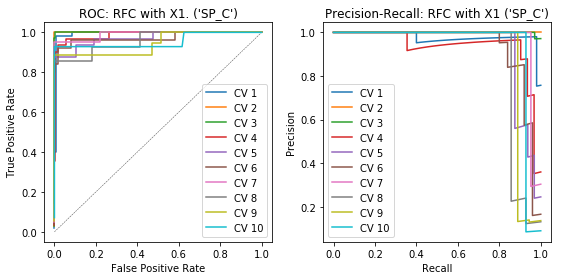

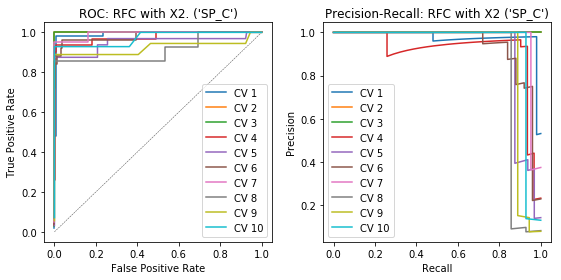

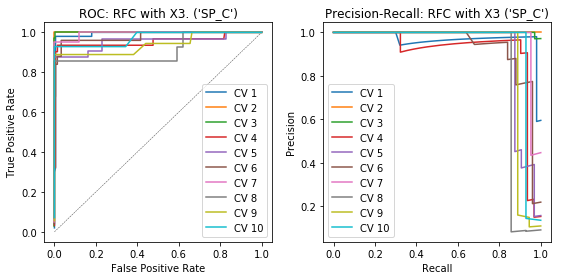

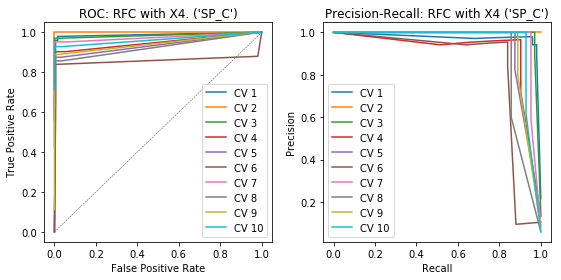

In [24]:
summarize_results(res_X1, clf_label='RFC with X1', target_label='SP_C', plot_result=True)
summarize_results(res_X2, clf_label='RFC with X2', target_label='SP_C', plot_result=True)
summarize_results(res_X3, clf_label='RFC with X3', target_label='SP_C', plot_result=True)
summarize_results(res_X4, clf_label='RFC with X4', target_label='SP_C', plot_result=True)

#### With LR

In [25]:
lrX1 = LogisticRegression(penalty='l1', C=10)
lrX2 = LogisticRegression(penalty='l1', C=10)
lrX3 = LogisticRegression(penalty='l1', C=10)
lrX4 = LogisticRegression(penalty='l1', C=10)

res_X1lr = classifyCV(lrX1, X1, df.itraq, name='LR', n_splits=10, num_terms=22736)
res_X2lr = classifyCV(lrX2, X2, df.itraq, name='LR', n_splits=10, num_terms=22736)
res_X3lr = classifyCV(lrX3, X3, df.itraq, name='LR', n_splits=10, num_terms=22736)
res_X4lr = classifyCV(lrX4, X4, df.itraq, name='LR', n_splits=10, num_terms=22736)

========== LR with X1 10-fold CV stats ==========
accuracy: 0.99 +/- 0.006
precision: 0.99 +/- 0.018
recall: 0.88 +/- 0.052
f1: 0.93 +/- 0.032
average_precision: 0.93 +/- 0.060
roc_auc: 0.96 +/- 0.037
Brier_loss: 0.01 +/- 0.007
========== LR with X2 10-fold CV stats ==========
accuracy: 0.99 +/- 0.008
precision: 0.99 +/- 0.018
recall: 0.90 +/- 0.062
f1: 0.94 +/- 0.040
average_precision: 0.93 +/- 0.058
roc_auc: 0.97 +/- 0.027
Brier_loss: 0.01 +/- 0.007
========== LR with X3 10-fold CV stats ==========
accuracy: 0.99 +/- 0.008
precision: 0.99 +/- 0.018
recall: 0.89 +/- 0.062
f1: 0.94 +/- 0.039
average_precision: 0.93 +/- 0.060
roc_auc: 0.97 +/- 0.026
Brier_loss: 0.01 +/- 0.006
========== LR with X4 10-fold CV stats ==========
accuracy: 0.99 +/- 0.008
precision: 0.99 +/- 0.018
recall: 0.89 +/- 0.063
f1: 0.94 +/- 0.040
average_precision: 0.92 +/- 0.062
roc_auc: 0.96 +/- 0.028
Brier_loss: 0.01 +/- 0.007


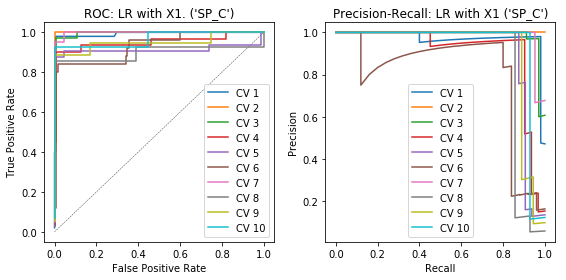

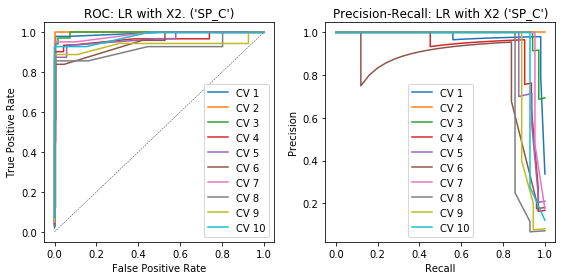

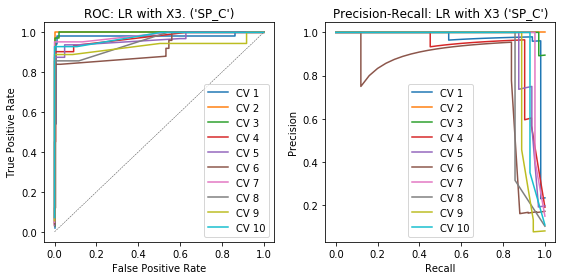

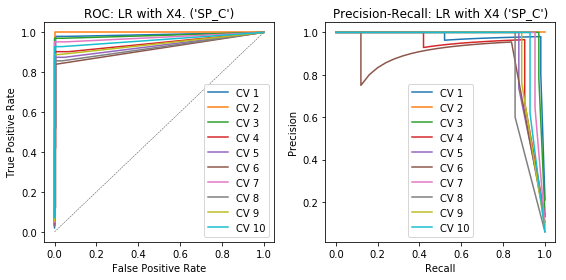

In [26]:
summarize_results(res_X1lr, clf_label='LR with X1', target_label='SP_C', plot_result=True)
summarize_results(res_X2lr, clf_label='LR with X2', target_label='SP_C', plot_result=True)
summarize_results(res_X3lr, clf_label='LR with X3', target_label='SP_C', plot_result=True)
summarize_results(res_X4lr, clf_label='LR with X4', target_label='SP_C', plot_result=True)

In [27]:
reverse_dict = {v:k for k, v in my_dictionary.token2id.items()}

In [28]:
inds_collection = [new_inds2, new_inds3, new_inds4]
for i, ind_set in enumerate(inds_collection):
    print('='*10, 'Feature Set %d' % (i+2),'='*10)
    for ind in ind_set:
        print(reverse_dict[ind])

========== Feature Set 2 ==========
discoverer
itraq
methanethiosulfonate
triple
gel
usa
label
manufacturer
cation
light
maxquant
isobaric
chain
ab
bias
biosystems
effort
mmts
probot
proteinpilot
sciex
qstar
tripletof
dissolution
paragon
reagent
absciex
multiplex
foster
reporter
phosphine
strata
ultremex
concord
kyoto
unity
========== Feature Set 3 ==========
itraq
label
manufacturer
cation
isobaric
ab
bias
biosystems
proteinpilot
paragon
reporter
kyoto
========== Feature Set 4 ==========
itraq
cation
paragon
